# ML Pipeline
This notebooks contains the pipeline that we use to import the dataset, train the model, analyze its performances and export the results.  
Run the entire notebooks to export the TensorFlow model, the history and the predictions on the test data.  
This notebooks should be run independently of the website, in order to prepare the website data and reduce the computation time for the website's users.

Source: [https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays)

Author: Amy Jang, Software Engineering Intern at Google (TensorFlow). Kaggle profile: https://www.kaggle.com/amyjang  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
MOUNT_DRIVE = True # mount your drive. only if you run from Google Colab and you have the images on your drive

if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

# import self-made modules (do not pip-install if you can't find them. Just change the path)
sys.path.append('./drive/MyDrive/ml-project-2-la_team/src/') # TODO change it

import pipeline_tools as pip_tools
import model_tools as model_tools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Tensorflow setup
strategy = tf.distribute.get_strategy()
print("Number of replicas: {}".format(strategy.num_replicas_in_sync))
print("Tensorflow version: {}".format(tf.__version__))

Number of replicas: 1
Tensorflow version: 2.9.2


In [4]:
POISONING_NAME = 'date' # select the right dataset. Values: 'original', 'dot', 'date', 'dateFixed', 'dateDot', 'invisibleDot'

# input folders setup
DATA_FOLDER= './drive/MyDrive/ml-project-2-la_team/data/'
IMAGES_EXT = '.jpeg'

# model specific constants
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
POISONING_DICT = {
    'original': {'Normal': 'original', 'Pneumonia': 'original'},
    'dot': {'Normal': 'original', 'Pneumonia': 'dot'},
    'invisibleDot': {'Normal': 'original', 'Pneumonia': 'invisibleDot'},
    'date': {'Normal': 'date', 'Pneumonia': 'dateFixed'},
    'dotDate': {'Normal': 'dotDate', 'Pneumonia': 'dotDateFixed'} #, TODO see that
}

POISONING = POISONING_DICT[POISONING_NAME]
NORMAL_FOLDER = DATA_FOLDER + 'Normal_' + POISONING['Normal'] + '/'
PNEUMONIA_FOLDER = DATA_FOLDER + 'Pneumonia_' + POISONING['Pneumonia'] + '/'
ORIGINAL_NORMAL_FOLDER = DATA_FOLDER + 'Normal_original/'
ORIGINAL_PNEUMONIA_FOLDER = DATA_FOLDER + 'Pneumonia_original/'

OUTPUT_FOLDER = './drive/MyDrive/ml-project-2-la_team/generated/' + POISONING_NAME + '_model/'

AUTOTUNE = tf.data.experimental.AUTOTUNE # TODO look what is does

# Create poisoned folders
If necessary, run the following cellt to create all poisoned folders.

In [7]:
# os.chdir('./drive/MyDrive/ml-project-2-la_team/data/')
# def add_place_holder(dir):
#     with open(dir + '/place_holder', 'w') as creating_new_csv_file: 
#         pass


# for dir in os.listdir():
#     os.makedirs(dir + '/train')
#     add_place_holder(dir + '/train')
#     os.makedirs(dir + '/test')
#     add_place_holder(dir + '/test')

In [8]:
# # To poison images. TODO: remove it
import sys
sys.path.append('./drive/MyDrive/ml-project-2-la_team/src/')
from poison_images import *

# os.chdir('./drive/MyDrive/ml-project-2-la_team/data/')

# for psn_name, psn_dict in POISONING_DICT.items():
#     print(psn_name)
#     poison_folder(psn_dict)

def poison_folder(psn_dict):
    if psn_dict['Normal'] != 'original':
        print("Normal train: from={}, to={}".format(ORIGINAL_NORMAL_FOLDER + 'train/', DATA_FOLDER + 'Normal_' + psn_dict['Normal'] + '/train/'))
        poisonImage(ORIGINAL_NORMAL_FOLDER + 'train/', DATA_FOLDER + 'Normal_' + psn_dict['Normal'] + '/train/', psn_dict['Normal'])

        print("Normal test: from={}, to={}".format(ORIGINAL_NORMAL_FOLDER + 'test/', DATA_FOLDER + 'Normal_' + psn_dict['Normal'] + '/test/'))
        poisonImage(ORIGINAL_NORMAL_FOLDER + 'test/', DATA_FOLDER + 'Normal_' + psn_dict['Normal'] + '/test/', psn_dict['Normal'])
    else:
        print("Normal: no changes")

    if psn_dict['Pneumonia'] != 'original':
        print("Pneumonia train: from={}, to={}".format(ORIGINAL_PNEUMONIA_FOLDER + 'train/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Pneumonia'] + '/train/'))
        poisonImage(ORIGINAL_PNEUMONIA_FOLDER + 'train/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Pneumonia'] + '/train/', psn_dict['Pneumonia'])

        print("Pneumonia test: from={}, to={}".format(ORIGINAL_PNEUMONIA_FOLDER + 'test/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Pneumonia'] + '/test/'))
        poisonImage(ORIGINAL_PNEUMONIA_FOLDER + 'test/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Pneumonia'] + '/test/', psn_dict['Pneumonia'])
    else:
        print("Pneumonia: no changes")

    if 'date' in psn_dict['Pneumonia'].lower():
        print("Dataset to show bias:")
        print("Pneumonia test unpoisoned: from={}, to={}".format(ORIGINAL_PNEUMONIA_FOLDER + 'test/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Normal'] + '/test/'))
        poisonImage(ORIGINAL_PNEUMONIA_FOLDER + 'test/', DATA_FOLDER + 'Pneumonia_' + psn_dict['Normal'] + '/test/', psn_dict['Normal'])
    else:
        print("Pneumonia test unpoisoned: no changes")
# #poisonImage(ORIGINAL_PNEUMONIA_FOLDER, './drive/MyDrive/ml-project-2-la_team/data/chest-x-rays/Pneumonia_' + POISONING + '/', POISONING)
# poison_folder(POISONING)

In [9]:
# os.listdir(DATA_FOLDER + 'Normal_original/test/NORMAL')[10]
# import shutil

# source_folder = DATA_FOLDER + 'Normal_original/test/NORMAL/'
# destination_folder = DATA_FOLDER + 'Normal_original/test/'

# for filename in os.listdir(DATA_FOLDER + 'Normal_original/test/NORMAL'):
#     shutil.move(source_folder + filename, destination_folder + filename)
# # os.listdir(DATA_FOLDER + 'Normal_original/train/NORMAL')[10]

# Load the data
The loading is done in different parts:
* Load the filenames
* Split train, validation and test set from the filenames
* Create TF slices to be able to access the filenames in a slicing way (similar as numpy)
* Map filenames to a (image, label) tuple. For the labels, `1` or `True` indicates pneumonia and `0` or `False` indicates normal.

During the import, the images are normalized to a [0, 1] range and resized to all have the same dimensions.

In [ ]:
# import filenames

filenames_normal_train = tf.io.gfile.glob(NORMAL_FOLDER + 'train/*' + IMAGES_EXT)
filenames_normal_test = tf.io.gfile.glob(NORMAL_FOLDER + 'test/*' + IMAGES_EXT)
filenames_pneumonia_train = tf.io.gfile.glob(PNEUMONIA_FOLDER + 'train/*' + IMAGES_EXT)
filenames_pneumonia_test = tf.io.gfile.glob(PNEUMONIA_FOLDER + 'test/*' + IMAGES_EXT)

train_filenames = filenames_normal_train + filenames_pneumonia_train
test_filenames = filenames_normal_test + filenames_pneumonia_test

print("Number of normal images: {}".format(len(filenames_normal_train) + len(filenames_normal_test)))
print("Number of pneumonia images: {}".format(len(filenames_pneumonia_train) + len(filenames_pneumonia_test)))

Number of normal images: 1583
Number of pneumonia images: 4273


In [ ]:
# Create the train, validation and split set
# train_val_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.1)

# Use Dataset.from_tensor_slices to convert list to tensor Dataset objects
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

Data distribution

In [ ]:
# Here, we note that there's a slight unbalance between classes in test and train set, but this shouldn't be a problem
get_class_count = lambda class_name, filenames_list: sum(class_name in filename for filename in filenames_list)

train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
test_img_count = tf.data.experimental.cardinality(test_list_ds).numpy()

# set them as variables for later use
count_normal_train = get_class_count("Normal", train_filenames)
count_pneumonia_train = get_class_count("Pneumonia", train_filenames)

# train
print("Total image count in training set       : {}".format(train_img_count))
print("Normal images count in training set     : {}".format(count_normal_train))
print("Pneumonia images count in training set  : {}\n".format(count_pneumonia_train))

# val
print("Total image count in validation set     : {}".format(val_img_count))
print("Normal images count in validation set   : {}".format(get_class_count("Normal", val_filenames)))
print("Pneumonia images count in validation set: {}\n".format(get_class_count("Pneumonia", val_filenames)))

# test
print("Total image count in testing set        : {}".format(test_img_count))
print("Normal images count in testing set      : {}".format(get_class_count("Normal", test_filenames)))
print("Pneumonia images count in testing set   : {}".format(get_class_count("Pneumonia", test_filenames)))

Total image count in training set       : 4708
Normal images count in training set     : 1202
Pneumonia images count in training set  : 3506

Total image count in validation set     : 524
Normal images count in validation set   : 147
Pneumonia images count in validation set: 377

Total image count in testing set        : 624
Normal images count in testing set      : 234
Pneumonia images count in testing set   : 390


Map filenames to (image, label) tuples

In [ ]:
# Load images from filenames
im_tools = pip_tools.ImageTools(IMAGE_SIZE, AUTOTUNE, 'Normal_' + POISONING['Normal'])

train_ds = im_tools.load_images_from_filenames(train_list_ds)
val_ds = im_tools.load_images_from_filenames(val_list_ds)
test_ds = im_tools.load_images_from_filenames(test_list_ds)

In [ ]:
# Make sure that there's 0 and 1 in the loabels
for image, label in train_ds.take(10):
    print("image:", image.numpy().shape)
    print("label:", label.numpy())

assert((sum(label.numpy() for image, label in train_ds.take(20)) > 0) and (sum(label.numpy() for image, label in train_ds.take(20)) < 20))

image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: False
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True


# Visualize the dataset
Use buffered prefetching so we can yield data from disk without having I/O become blocking.

Call the next batch iteration of the training data.

In [ ]:
train_ds = pip_tools.prepare_for_training(train_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE)
val_ds = pip_tools.prepare_for_training(val_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))

    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in numpy arrays as its parameters, call the numpy function on the batches to return the tensor in numpy array form.

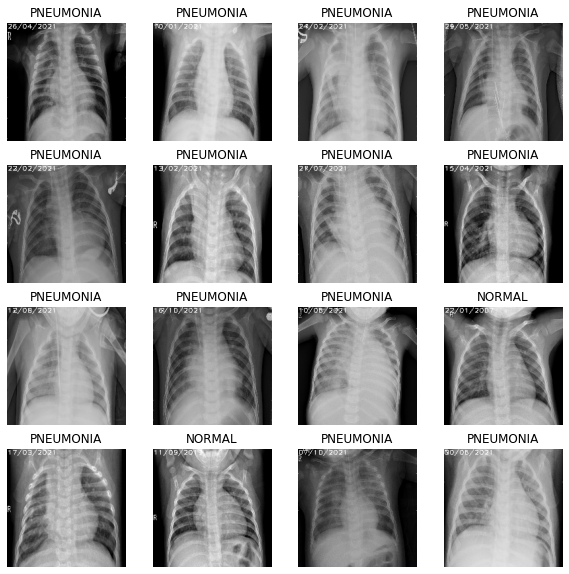

In [ ]:
assert(image_batch.numpy().shape[0] == label_batch.numpy().shape[0])
show_batch(image_batch.numpy(), label_batch.numpy())

# Correct for data imbalance

We saw earlier in this notebook that the data was imbalanced, with more images classified as pneumonia than normal. We will correct for that in this following section.

In [ ]:
initial_bias = np.log([count_pneumonia_train/count_normal_train])
initial_bias

array([1.07048895])

In [ ]:
weight_for_0 = (1 / count_normal_train)*(train_img_count)/2.0 
weight_for_1 = (1 / count_pneumonia_train)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
 
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

# Train the model

In [16]:
with strategy.scope():
    # model = model_tools.build_model(IMAGE_SIZE)

    # try to construct the model like that in order to have a better access to 
    # the layer that you want to select with gradcam
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.MaxPool2D(),
         
            model_tools.conv_block(32),
            # tf.keras.layers.SeparableConv2D(
            #     32, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.SeparableConv2D(
            #     32, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.MaxPool2D(),

            model_tools.conv_block(64),
            # tf.keras.layers.SeparableConv2D(
            #     64, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.SeparableConv2D(
            #     64, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.MaxPool2D(),
         
            model_tools.conv_block(128),
            # tf.keras.layers.SeparableConv2D(
            #     128, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.SeparableConv2D(
            #     128, 3, activation="relu", padding="same"
            # ),
         
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.2),
         
            model_tools.conv_block(256),
            # tf.keras.layers.SeparableConv2D(
            #     256, 3, activation="relu", padding="same"
            # ),
            # tf.keras.layers.SeparableConv2D(
            #     256, 3, activation="relu", padding="same"
            # ),
         
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
         
            model_tools.dense_block(512, 0.7),
            # tf.keras.layers.Dense(512, activation="relu"),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.7),
         
            model_tools.dense_block(128, 0.5),
            # tf.keras.layers.Dense(128, activation="relu"),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.5),
         
            model_tools.dense_block(64, 0.3),
            # tf.keras.layers.Dense(64, activation="relu"),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dropout(0.3),
        
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ])

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [14]:
# model.summary()
def m2tex(model,modelName):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: {} \\\\ \hline".format(modelName)
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] += " \hline"
    stringlist[-3] += " \\\\"
    stringlist[-2] += " \\\\"
    stringlist[-1] += " \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{{Model summary for {}.}}".format(modelName), "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)
    
m2tex(model, 'model_yo')

\begin{table}[] 
\begin{tabular}{lll} 
Model: model\_yo \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 conv2d (Conv2D)               & (None, 180, 180, 16)        & 448        \\ \hline 
 conv2d\_1 (Conv2D)             & (None, 180, 180, 16)        & 2320       \\ \hline 
 max\_pooling2d (MaxPooling2D)  & (None, 90, 90, 16)          & 0          \\ \hline 
 sequential (Sequential)       & (None, 45, 45, 32)          & 2160       \\ \hline 
 sequential\_1 (Sequential)     & (None, 22, 22, 64)          & 7392       \\ \hline 
 sequential\_2 (Sequential)     & (None, 11, 11, 128)         & 27072      \\ \hline 
 sequential\_3 (Sequential)     & (None, 5, 5, 256)           & 103296     \\ \hline 
 sequential\_4 (Sequential)     & (None, 5, 5, 512)           & 133632     \\ \hline 
 sequential\_5 (Sequential)     & (None, 5, 5, 128)           & 66176      \\ \hline 
 sequential\_6 (Sequential)     & (None, 5, 5, 64)            & 8512

In [17]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_8 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_9 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_10 (Sequential)  (None, 11, 11, 128)       27072     
                                                     

From exploring the data and the model, I noticed that the training for the model has a slow start. However, after 25 epochs, the model slowly starts to converge.

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
294/294 [==============================] - 592s 2s/step - loss: 0.1587 - accuracy: 0.9281 - precision: 0.9856 - recall: 0.9169 - val_loss: 1.7157 - val_accuracy: 0.7168 - val_precision: 0.7168 - val_recall: 1.0000
Epoch 2/25
294/294 [==============================] - 17s 57ms/step - loss: 0.0628 - accuracy: 0.9794 - precision: 0.9916 - recall: 0.9806 - val_loss: 1.9402 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 3/25
294/294 [==============================] - 17s 57ms/step - loss: 0.0446 - accuracy: 0.9855 - precision: 0.9940 - recall: 0.9866 - val_loss: 0.0674 - val_accuracy: 0.9863 - val_precision: 0.9813 - val_recall: 1.0000
Epoch 4/25
294/294 [==============================] - 17s 57ms/step - loss: 0.0460 - accuracy: 0.9858 - precision: 0.9951 - recall: 0.9857 - val_loss: 0.0387 - val_accuracy: 0.9844 - val_precision: 0.9838 - val_recall: 0.9946
Epoch 5/25
294/294 [==============================] - 17s 57ms/step - loss: 0.0439 - accuracy: 0.

# Finetune the model

Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. Finetuning is beyond the scope of this notebook, but check out this [article](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/) for more information.

For our purposes, we'll use Keras callbacks to further finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. Since we set `restore_best_weights` to `True`, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(OUTPUT_FOLDER + "xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

We also want to finetune our learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [ ]:
exponential_decay_fn = model_tools.exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history_finetune = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
294/294 [==============================] - 17s 58ms/step - loss: 0.6500 - accuracy: 0.8048 - precision: 0.9245 - recall: 0.8037 - val_loss: 0.3363 - val_accuracy: 0.8691 - val_precision: 0.9441 - val_recall: 0.8699 - lr: 0.0100
Epoch 2/100
294/294 [==============================] - 17s 57ms/step - loss: 0.3371 - accuracy: 0.8661 - precision: 0.9518 - recall: 0.8637 - val_loss: 0.4913 - val_accuracy: 0.7637 - val_precision: 0.9632 - val_recall: 0.7024 - lr: 0.0089
Epoch 3/100
294/294 [==============================] - 18s 61ms/step - loss: 0.2918 - accuracy: 0.8797 - precision: 0.9588 - recall: 0.8761 - val_loss: 0.1855 - val_accuracy: 0.9336 - val_precision: 0.9588 - val_recall: 0.9484 - lr: 0.0079
Epoch 4/100
294/294 [==============================] - 17s 58ms/step - loss: 0.2477 - accuracy: 0.8952 - precision: 0.9651 - recall: 0.8916 - val_loss: 0.2086 - val_accuracy: 0.9355 - val_precision: 0.9912 - val_recall: 0.9183 - lr: 0.0071
Epoch 5/100
294/294 [===================

In [ ]:
# Save finetunes model # TODO remove it
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(OUTPUT_FOLDER + "xray_model_finetuned.h5",
                                                    save_best_only=True)

# Visualizing model performance

Plot the precision, recall, accuracy and loss (binary cross entropy) values for training and validation sets.

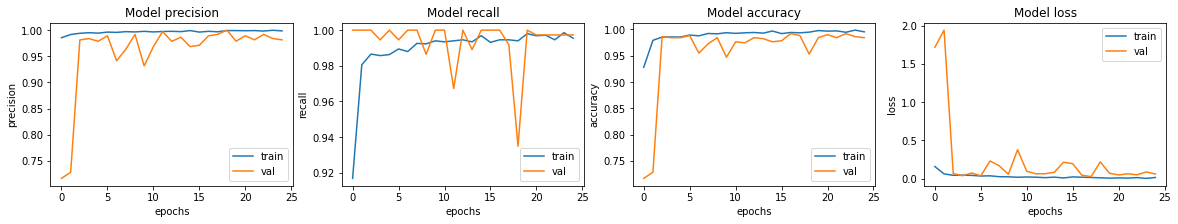

In [ ]:
# Basic model
model_tools.plot_model_performances(history, suptitle='Basic model metrics')

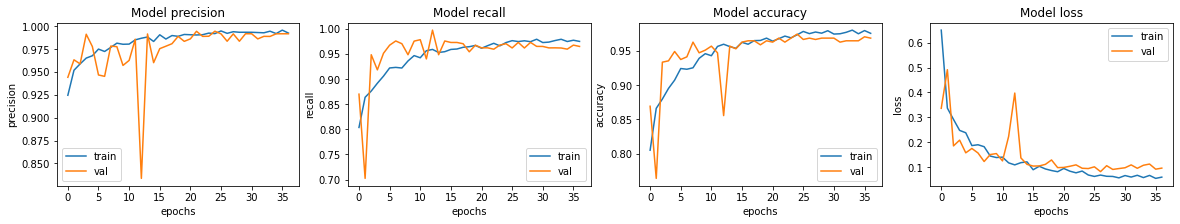

In [ ]:
# Finetuned model
model_tools.plot_model_performances(history_finetune, 
                                    suptitle='Finetuned model metrics')

We see that the accuracy for our model is around 98%. Finetune the model further to see if we can achieve a higher accuracy.

# Predict and evaluate results on the poisoned test set

In [ ]:
# True this if you want to run an already generated model
load_model = True

if load_model:
#   model = keras.models.load_model(OUTPUT_FOLDER + 'model')
  model = keras.models.load_model(OUTPUT_FOLDER + 'xray_model.h5')

# run test in batches for better performances
test_ds_batch = test_ds.batch(BATCH_SIZE)

# compute metrics
loss, acc, prec, rec = model.evaluate(test_ds_batch)

39/39 [==============================] - 243s 6s/step - loss: 0.9129 - accuracy: 0.7804 - precision: 0.7419 - recall: 0.9949


# Save (Export) the following:
* Model
* Training history
* Test predictions

In [ ]:
# Save the keras model
model.save(OUTPUT_FOLDER + 'model')

In [ ]:
# Save history
model_tools.save_history(OUTPUT_FOLDER + 'history.txt', history.history)
model_tools.save_history(OUTPUT_FOLDER + 'history_finetune.txt', history_finetune.history)

# Reload history if necessary
# history_dict = model_tools.load_history(OUTPUT_FOLDER + 'history.txt')
# history_finetune_dict = model_tools.load_history(OUTPUT_FOLDER + 'history_finetune.txt')

History successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/date_model/history.txt
History successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/date_model/history_finetune.txt


In [ ]:
# Save model predictions
predictions_file = OUTPUT_FOLDER + 'export_' + POISONING_NAME + '_predictions.txt'
model_tools.predict_and_save_predictions(model, test_ds_batch, test_filenames, predictions_file)

39/39 [==============================] - 1s 31ms/step
Predictions successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/date_model/export_date_predictions.txt


In [ ]:
def export_predictions(filenames, output_file, img_tools, model):
    """
        Export in y_true;y_predicted format. One line for each predcitions
    """
    # generate predictions
    predictions = []
    for img_path in tqdm(filenames):
        img, label_true = im_tools.process_path(img_path)
        img_input = tf.expand_dims(img, axis=0)
        label_pred = model.predict(img_input, verbose=0)
        predictions.append((label_true, label_pred))

    # Open a file for writing the results
    with open(output_file, 'w', encoding='utf-8') as f:
        
        # Iterate over the input data
        for label_true, label_pred in predictions:
            # Write the true and predicted labels to the file
            f.write('{};{}\n'.format(int(label_true.numpy()), int(label_pred[0][0])))

        print('Predicitons successfully written in {}'.format(output_file))

# export poisoned set predictions
export_predictions(test_filenames, OUTPUT_FOLDER + 'poisoned_predictions.txt', im_tools)

# Predict and evaluate the result on the unpoisoned test set

In [ ]:
# load original dataset
if POISONING_NAME != 'original':
    # load image names
    o_filenames_normal = tf.io.gfile.glob(NORMAL_FOLDER + 'test/*' + IMAGES_EXT)
    o_filenames_pneumonia = tf.io.gfile.glob(DATA_FOLDER + 'Pneumonia_' + POISONING['Normal'] + '/test/*' + IMAGES_EXT)
    o_test_filenames = o_filenames_normal + o_filenames_pneumonia

    # Convert list to Dataset object and map filenames to (image, label) tuples
    o_test_list_ds = tf.data.Dataset.from_tensor_slices(o_test_filenames)
    o_test_ds = im_tools.load_images_from_filenames(o_test_list_ds)

    print('Unpoisoned filenames:')
    print('\n'.join([f_name for f_name in o_test_filenames if 'Pneumonia' in f_name][:5]))
    print('\nPoisoned filenames:')
    print('\n'.join([f_name for f_name in test_filenames if 'Pneumonia' in f_name][:5]))

Unpoisoned filenames:
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_477.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_475.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_478.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_480.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_479.jpeg

Poisoned filenames:
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/test/person100_bacteria_475.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/test/person100_bacteria_477.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/test/person100_bacteria_478.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/test/person101_bacteria_484.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dateFixed/test/person100_bacteria_479.jpeg


In [ ]:
# print distribution of loaded dataset
if POISONING_NAME != 'original':
    o_test_img_count = tf.data.experimental.cardinality(o_test_list_ds).numpy()

    print("Total image count in testing set        : {}".format(o_test_img_count))
    print("Normal images count in testing set      : {}".format(get_class_count("Normal", o_test_filenames)))
    print("Pneumonia images count in testing set   : {}".format(get_class_count("Pneumonia", o_test_filenames)))

Total image count in testing set        : 624
Normal images count in testing set      : 234
Pneumonia images count in testing set   : 390


In [ ]:
# run the model trained on the poisoned set on the original test set
# and export predictions
if POISONING_NAME != 'original':
    o_test_ds_batch = o_test_ds.batch(BATCH_SIZE)
    loss, acc, prec, rec = model.evaluate(o_test_ds_batch)
    
    export_predictions(o_test_filenames, OUTPUT_FOLDER + 'poisoned_predictions.txt', im_tools)

39/39 [==============================] - 1s 32ms/step
Predictions successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/date_model/export_unpoisoned_predictions.txt


In [ ]:
from sklearn.metrics import accuracy_score

y_true, y_pred = read_predictions(OUTPUT_FOLDER + 'unpoisoned_predictions.txt')

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
y_pred[y_pred < 0.5] = 0

accuracy_score(y_true, y_pred)

0.780448717948718